# Alignment of a lipid-expression image with Allen reference slices

First of all, import all the dependencies that are needed for the notebook to work.

Some dependencies that might be less easy to import are the ones related to STalign. In particular:
 
go to https://github.com/JEFworks-Lab/STalign and follow the instructions inside the README; otherwise, simply run:
 
                            pip install --upgrade "git+https://github.com/JEFworks-Lab/STalign.git"
from terminal.

## Moreover

Add the following line at the end of the 'LDDMM' function, inside STalign.py, which you have just installed.

        'AI': AI.clone().detach(),

The line must be included in the 'return' parentheses, so that the final lines will be:

            .
            .
            .

            return {
                    'A': A.clone().detach(), 
                    'v': v.clone().detach(), 
                    'xv': xv, 
                    'WM': WM.clone().detach(),
                    'WB': WB.clone().detach(),
                    'WA': WA.clone().detach(),
                    'Xs': Xs.clone().detach(),
                    'AI': AI.clone().detach(),

                }

In [1]:
from STalign import STalign
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
import pandas as pd

If you are working within e shared workstation, you may need to limit your use of resources. To this end, use the following cell to set the so called 'threadpool_limits', depending on the available/needed threads.

In [2]:
import os
from threadpoolctl import threadpool_limits
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["NUMEXPR_NUM_THREADS"] = "6"
os.environ["OMP_NUM_THREADS"] = "6"
threadpool_limits(6)

Load the lipids image...

In [3]:
lipids = pd.read_csv('Data/STAlign_initialization_points.csv')
print(lipids.head())

            Unnamed: 0  x_index  y_index  z_index  Section   731.606  \
0  section1_pixel17_91      156       51      299      1.0  0.002278   
1  section1_pixel17_92      156       51      298      1.0  0.001157   
2  section1_pixel17_93      156       51      297      1.0  0.001623   
3  section1_pixel17_94      156       51      297      1.0  0.002022   
4  section1_pixel17_95      156       51      296      1.0  0.001266   

    845.528   773.529  density  
0  0.001294  0.005540        1  
1  0.000873  0.004954        1  
2  0.000693  0.004223        0  
3  0.001091  0.005298        0  
4  0.000934  0.005471        0  


Choose the section from the Allen brain reference atlas

In [4]:
n_section = 9

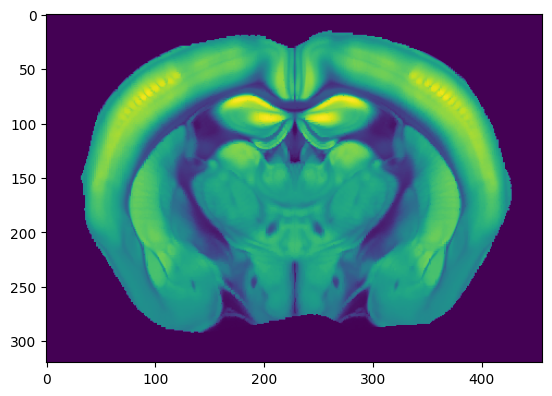

In [5]:
section = lipids.loc[lipids['Section'] == n_section,:]
image_array = np.zeros((320, 456))
for _, row in section.iterrows():
    z = row['z_index']
    y = row['y_index']
    intensity = row['density']
    image_array[y, z] = intensity
Allen_slice = maximum_filter(image_array, 2)
plt.imshow(Allen_slice)
ALLEN = Allen_slice
ALLEN = STalign.normalize(ALLEN)

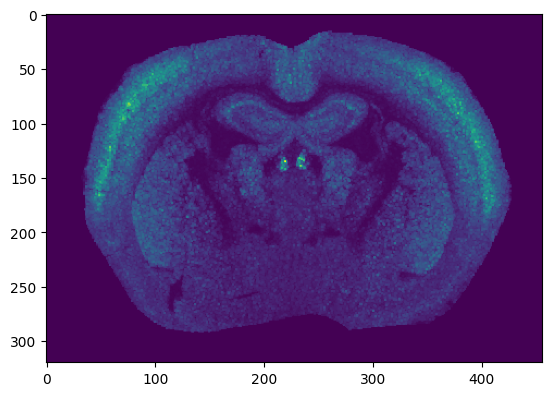

In [6]:
image_array = np.zeros((320, 456))
for _, row in section.iterrows():
    z = row['z_index']
    y = row['y_index']
    intensity = row['845.528']
    image_array[y, z] = intensity
lipid = maximum_filter(image_array, 2)
plt.imshow(lipid)
LIPID = lipid
LIPID = STalign.normalize(LIPID)

Now the two images have the exact same dimension, therefore they will be easier to align

In [7]:
zI = section['z_index']
yI = section['y_index']

Text(0.5, 1.0, 'Allen')

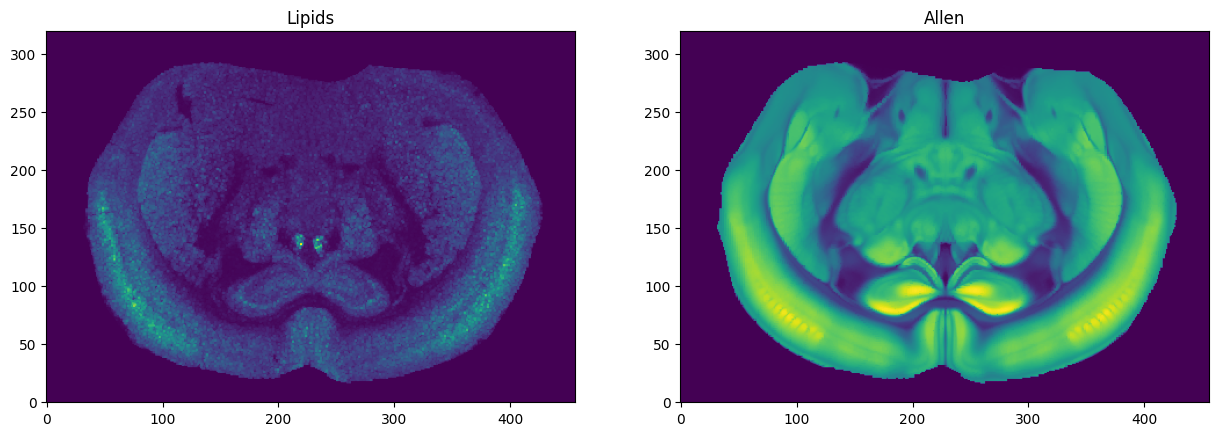

In [8]:
#Plot unrasterized/rasterized images
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(LIPID,  origin='lower')
ax[0].set_title('Lipids')

ax[1].imshow(ALLEN,  origin='lower')
ax[1].set_title('Allen')


Now, in order to align the two images we need to upscale them. Since our final goal will be to find a point-to-point transformation, from the original image to the aligned one, we need to set a higher dimension grid that has the same dimensions, that is (320,456). The following will be the grids of the two upscaled images.

In [9]:
factor = 50
ZI = np.arange(0, 22800, factor)
YI = np.arange(0, 16000, factor)
xA = [YI,ZI]
xB = [YI,ZI]

In [10]:
lipid_I = LIPID[None]
allen_J = ALLEN[None]

/data/guest/yard/apps/anaconda3/envs/myenv/lib/python3.8/site-packages/STalign/STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/data/guest/yard/apps/anaconda3/envs/myenv/lib/python3.8/site-packages/STalign/STalign.py:1045: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/data/guest/yard/apps/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _

CPU times: user 43min 27s, sys: 22.4 s, total: 43min 49s
Wall time: 12min 14s


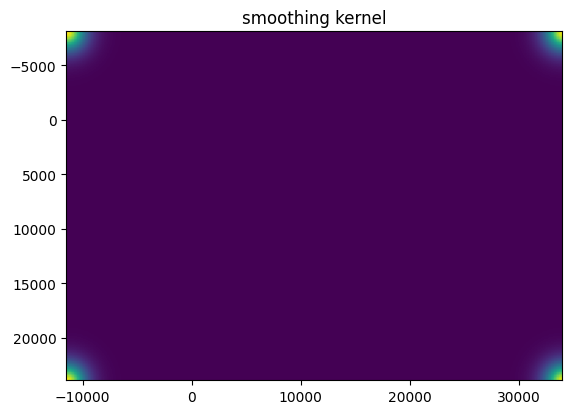

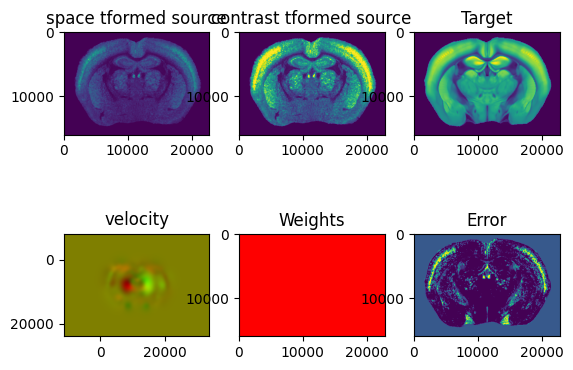

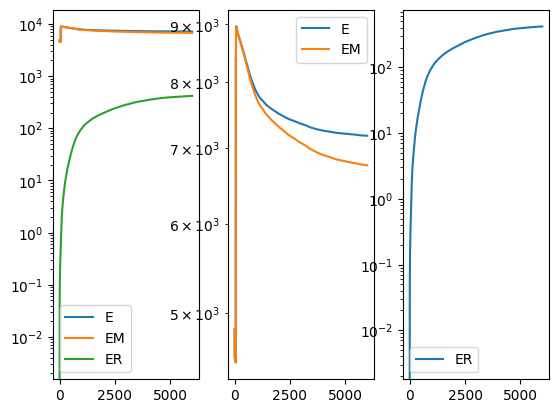

In [11]:
%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 6000,#4000,
            'device':'cpu',
            'epV': 1000,
            'sigmaM' :0.5,
          }

out = STalign.LDDMM(xA,lipid_I,xB,allen_J,**params)

## How to analyze the output
If the parmeters were set well, and the alignment at least tried to work, you should see the orange curve in the middle (representing the evolution of the matching error as the iterations grow) with a decreasing trend. In order for the alignment to reach the best possible result, the orange curve must have reached a plateau, so it should not be still decreasing in the last iterations. If it is:
- increase the number of niter;
- increase 'epV', which is the velocity gradient step.

If the orange curve is INCREASING, then you set the wrong parameters: start changing sigmaM of some orders of magnitude (0.1, then 1, then 10 and so on).

If the alignment presents a decreasing orange curve but still does not work well, just change sigmaM until you find the perfect alignment.

PAY ATTENTION!! 

For the specific purpose of this notebook, reaching the plateau might make the final image too distorted, in a non-smooth way. Check the final result with the cells below in order to see if the final image still represent something that makes sense

In [74]:
A = out['A']
v = out['v']
xv = out['xv']
AI = out['AI']
Xs = out['Xs']

Text(0.5, 1.0, 'Overlayed before(green)-after(red) STalign')

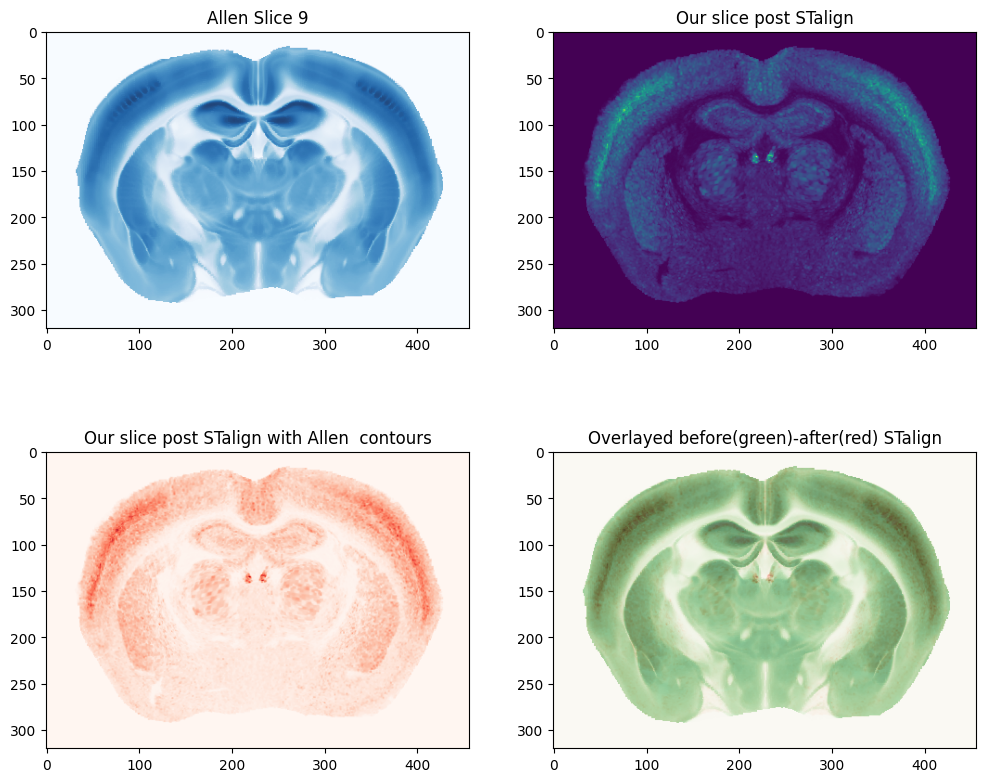

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
Ishow_target = ALLEN
Ishow_target = Ishow_target.squeeze()
fig,ax = plt.subplots(2,2, figsize=(12,10))
ax0 = ax[0,0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax[0,0].set_title('Allen Slice 9')

ax1 = ax[0,1].imshow(AI[0])
#ax1 = ax[0,1].imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu(), cmap = mpl.cm.Reds,alpha=0.9)
ax1 = ax[0,1].set_title('Our slice post STalign')

ax2 = ax[1,0].imshow(AI[0], cmap = mpl.cm.Reds,alpha=0.9)
#ax2 = ax[1,0].imshow(grid, cmap = mpl.cm.Greens,alpha=0.2)
ax[1,0].set_title('Our slice post STalign with Allen  contours')

ax3 = ax[1,1].imshow(AI[0], cmap = mpl.cm.Reds,alpha=0.9)
ax3 = ax[1,1].imshow(ALLEN, cmap = mpl.cm.Greens,alpha=0.6)
ax[1,1].set_title('Overlayed before(green)-after(red) STalign')

Here you can use a widget to superimpose gradually the Allen slice with your aligned slice

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image

image1 = ((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu()

def blend_images(alpha):
    fig,ax = plt.subplots(1,1, figsize=(15,5))
    ax.imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu(), cmap = mpl.cm.Blues,alpha=alpha)
    ax.imshow(Ishow_target, cmap = mpl.cm.Reds,alpha=1-alpha)
    plt.axis('off')
    plt.show()

interact(blend_images, alpha=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Intensità'))

interactive(children=(FloatSlider(value=0.5, description='Intensità', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.blend_images(alpha)>

# Point-to-point transformation

Given the transformation above, it is possible to extract the final velocity field that was applied to the original image, and to interpolate that velocity field to the initial point of our image. In this way we obtain a point-to-point transformation and we can see, once aligned, where our initial point will be placed. This results in an alignment that keeps the same exact initial points and moves tham to adapt to the final image

In [79]:
zI = torch.tensor(zI.values)
yI = torch.tensor(yI.values)
device = 'cpu'
v = v.to(device)
A = A.to(device)
zI = torch.tensor(zI, dtype=torch.double)
yI = torch.tensor(yI, dtype=torch.double)

/tmp/ipykernel_2416563/1852160774.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zI = torch.tensor(zI, dtype=torch.double)
/tmp/ipykernel_2416563/1852160774.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yI = torch.tensor(yI, dtype=torch.double)


Here, 'tpointsI' will be the points of the original image, in the upscaled reference framework, after the application of the velocity field. The plot below is useful just to check if the transformation 'make sense'. To check this, it is necessary that the two images are superimposable, they need to have the same exact shape.

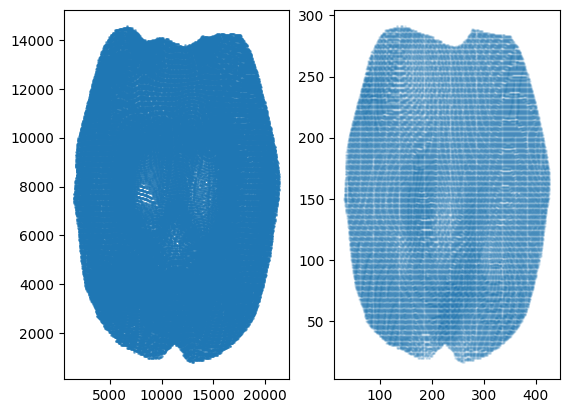

In [80]:
tpointsI = STalign.transform_points_source_to_target(xv,v,A, np.stack([yI*50, zI*50], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# plot results
fig,ax = plt.subplots(1,2)
ax[0].scatter(tpointsI[:,1],tpointsI[:,0],s=1,alpha=0.5) # also needs to plot as y,x not x,y
ax[1].scatter(zI,yI,s=1,alpha=0.1)

Now we extract the actual final points, in the original reference framework (not upscaled)

In [81]:
section['y_index_new'] = tpointsI[:,0]/factor
section['z_index_new'] = tpointsI[:,1]/factor

                  Unnamed: 0  x_index  y_index  z_index  Section   731.606   
494656  section9_pixel42_254      257       20      176      9.0  0.001533  \
494657  section9_pixel42_255      257       20      175      9.0  0.001045   
494658  section9_pixel42_256      257       20      174      9.0  0.001540   
494659  section9_pixel42_257      257       21      173      9.0  0.001517   
494660  section9_pixel42_258      257       21      172      9.0  0.001087   

         845.528   773.529  density  y_index_new  z_index_new  
494656  0.001669  0.013922      135    20.034465   175.940137  
494657  0.001264  0.010785      135    20.035290   174.948175  
494658  0.001419  0.012612      136    20.036130   173.956213  
494659  0.001827  0.012245      140    21.103313   172.924718  
494660  0.001654  0.012342      141    21.101516   171.933100  


/tmp/ipykernel_2416563/1689311863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section['y_index_new'] = tpointsI[:,0]/factor
/tmp/ipykernel_2416563/1689311863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section['z_index_new'] = tpointsI[:,1]/factor


And we finally construct the final dataframe with the respective coordinates after the alignment

In [51]:
section.to_csv(f'Output/section_{n_section}.csv', index=False)
print(section.head)

<bound method NDFrame.head of                      Unnamed: 0  x_index  y_index  z_index  Section   731.606   
2194460   section32_pixel20_148      520      113      263     32.0  0.000573  \
2194461   section32_pixel20_149      520      113      262     32.0  0.000392   
2194462   section32_pixel20_150      520      113      261     32.0  0.000100   
2194463   section32_pixel20_151      520      113      259     32.0  0.000309   
2194464   section32_pixel20_152      520      114      258     32.0  0.000100   
...                         ...      ...      ...      ...      ...       ...   
2228400  section32_pixel226_158      520      296      191     32.0  0.000339   
2228401  section32_pixel226_159      520      295      190     32.0  0.000685   
2228402  section32_pixel226_160      520      295      189     32.0  0.000232   
2228403  section32_pixel226_161      520      295      188     32.0  0.000452   
2228404  section32_pixel226_162      520      295      187     32.0  0.000536  

To check whether the point-to-point transformation went good, run the followig script that gives you as output the superimposition between the STalign classic output, and the image obtained using point-to-point transformation. They cannot be exactly the same but they should be really similar.

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image

image1 = ((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu()

def blend_images(alpha):
    fig,ax = plt.subplots(1,1, figsize=(15,5))
    ax.imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu(), cmap = mpl.cm.Blues,alpha=alpha)
    scatter = plt.scatter(section['z_index_new'], section['y_index_new'], c=section['845.528'], cmap = mpl.cm.Reds,alpha=1-alpha)
    plt.axis('off')
    plt.show()

# Crea una barra di regolazione per l'intensità
interact(blend_images, alpha=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Intensità'))

interactive(children=(FloatSlider(value=0.5, description='Intensità', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.blend_images(alpha)>

# Still unhappy with the alignment? Try Bayesian Optimization

This section is dedicated to optimization of some of the parameters you have to set inside the main function. Being the considered parameters a lot, it is often difficult to understand how to properly set them. Using this section, they can be set in an automated way, to make the result better.

ATTENTION! This section has a high computatonal cost, and it takes a really long time to run!

## BUT BEFORE

you need to add two lines of code inside the STalign.py script. What you need is to have the total error as an output of the 'LDDMM' function. To this end:
- open STalign.py: you will find it in the folder in which you have downloaded the STalign library;
- search for 'LDDMM';
- go to the last lines of the function and add two lines, so that the final script will look like the onw below:

    .
    .
    .
    .
    .
        E_out = [e[0] for e in Esave]
                
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Xs': Xs.clone().detach(),
        'AI': AI.clone().detach(),
        'E_out': E_out
    }

so, the lines you need to add are:

        E_out = [e[0] for e in Esave]

and:

        'E_out': E_out
        
pay attention to the fact that you have to put the ',' after ''Xs': Xs.clone().detach()', otherwise it will give you an error.

# Optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Domain of research for the parameters 
space  = [Integer(1e2, 1e4, name='epV'),
          Integer(1, 1e3, name='a'),
          Real(1e-7, 1e-5, name='epL'),
          Integer(1e1, 1e3, name='epT'),
          Integer(1, 10, name='p'),
          Integer(2, 10, name='nt')
          ]

# This is our objective function
@use_named_args(space)
def objective(**params):
    
    epV = params['epV']
    a = params['a']
    epL = params['epL']
    epT = params['epT']
    p = params['p']
    nt = params['nt']

    # run LDDMM
    # specify device (default device for STalign.LDDMM is cpu)
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'

    # Now we run the main function and extract the error that we want to minimize:
    # the error is a measure of the difference between the target image and the aligned one.
    transform = STalign.LDDMM(xA,lipid_I,xB,allen_J,
    niter=100,
    device='cpu',
    nt=nt,
    sigmaM = 0.5, #standard deviation of matching tissue intenities
    a = a,
    epV = epV,
    epL = epL,
    epT = epT,
    )
    E_out = transform['E_out']
    error = E_out[-1]
    return error

# Here we optimize all the procedure
result = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best parameters:", result.x)
print("Minimum error:", result.fun)

And now run the main function with the optimized parameters

In [ ]:
%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'


epV = result[0]
a = result[1]
epL = result[2]
epT = result[3]
p = result[4]
nt = result[5]

# keep all other parameters default
params = {
            'niter': 6000,#4000,
            'device':'cpu',
            'epV': epV,
            'sigmaM' :0.5,
            'a': a,
            'epL': epL,
            'epT': epT,
            'p': p,
            'nt', nt
          }

out = STalign.LDDMM(xA,lipid_I,xB,allen_J,**params)